### Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from dateutil.relativedelta import relativedelta
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

/Users/gulsumasenacakir/churn-prediction-ML/newenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data prep

Loading data

In [2]:
path = kagglehub.dataset_download("shriyashjagtap/e-commerce-customer-for-behavior-analysis")

print("Path to dataset files:", path)

Path to dataset files: /Users/gulsumasenacakir/.cache/kagglehub/datasets/shriyashjagtap/e-commerce-customer-for-behavior-analysis/versions/4


In [3]:
files = os.listdir(path)
print("Files in the dataset:")
for file_name in files:
    print(file_name)

Files in the dataset:
ecommerce_customer_data_large.csv
ecommerce_customer_data_custom_ratios.csv


In [4]:
data = pd.read_csv('/Users/gulsumasenacakir/.cache/kagglehub/datasets/shriyashjagtap/e-commerce-customer-for-behavior-analysis/versions/4/ecommerce_customer_data_large.csv')
data.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [5]:
data.shape

(250000, 13)

In [6]:
def data_quality(data):
    missing = data.isnull().sum()
    unique_val = data.nunique()
    datatypes = data.dtypes
    check = pd.DataFrame({
        'missing': missing,
        'unique value': unique_val,
        'datatypes': datatypes
    })
    return check

In [7]:
data_check = data_quality(data)
data_check

,missing,unique value,datatypes
Customer ID,0,49661,int64
Purchase Date,0,249728,object
Product Category,0,4,object
Product Price,0,491,int64
Quantity,0,5,int64
Total Purchase Amount,0,5245,int64
Payment Method,0,3,object
Customer Age,0,53,int64
Returns,47382,2,float64
Customer Name,0,39878,object


The only column with missing values is 'Returns'.

Moreover, the 'Customer Age' and 'Age' columns seem to be the same. Therefore, I will check them.

In [8]:
if data['Customer Age'].equals(data['Age']):
    print('they are identical')
else:
    print('they are not identical')

they are identical


In [9]:
data = data.drop('Customer Age', axis = 1) # remove one of the identical columns

I need to handle the missing values. First, I will calculate the percentage of the missing values in the 'Returns' column.

In [10]:
null_percentage = data['Returns'].isnull().sum()/len(data)
null_percentage

0.189528

The percentage of missing values in the 'Returns' column is 19%. Since this is a significant portion of the data, I will remove the rows containing missing values to maintain the integrity of the analysis.

In [11]:
df = data.dropna()

In [12]:
df = df.sort_values('Customer ID', ascending=True) 

In [13]:
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Customer Name,Age,Gender,Churn
160921,1,2021-04-08 18:33:34,Books,456,5,5148,Credit Card,0.0,Dominic Cline,67,Female,0
225933,2,2023-07-03 17:26:19,Books,190,1,4693,Credit Card,1.0,Crystal Day,42,Female,0
225937,2,2023-04-26 10:10:00,Electronics,461,5,604,Cash,0.0,Crystal Day,42,Female,0
225936,2,2022-09-04 02:27:42,Electronics,227,4,1002,PayPal,1.0,Crystal Day,42,Female,0
225935,2,2022-03-14 04:31:25,Home,376,4,4726,Cash,1.0,Crystal Day,42,Female,0


The 'Customer Name' column will be removed due to the presence of the 'Customer ID' column, which serves as a unique identifier. The 'Customer Name' column does not provide additional valuable information for the analysis and can be safely removed.

In [14]:
df = df.drop('Customer Name', axis=1)

The "Purchase Date" column contains both date and time information, which are being separated into distinct components. The date is extracted as a string, and the hour is also extracted separately. Additionally, a new "year_month" variable is created for exploratory data analysis (EDA), which represents the year and month in a 'YYYY-MM' format.

In [15]:
df[['Purchase Date']].dtypes

Purchase Date    object
dtype: object

In [16]:
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
df['date'] = df['Purchase Date'].dt.date.astype(str)
df['hour'] = df['Purchase Date'].dt.hour
df['year_month'] = df['Purchase Date'].dt.strftime('%Y-%m')

Time interval in the dataset:

In [17]:
df['date'].min(), df['date'].max()

('2020-01-01', '2023-09-13')

In [18]:
df = df.drop('Purchase Date', axis = 1)

The column 'Total Purchase Amount' represents the total amount spent by the customer in each transaction. However, it does not reflect the total price paid by the customer, as it may include discounts, taxes, or other adjustments. Therefore, I will create a new column to capture the actual price paid by the customer in each transaction, excluding these factors.

In [19]:
df['total_price'] = df['Product Price'] * df['Quantity']

I will create a new column for age groups to facilitate the exploratory data analysis (EDA).

In [20]:
df['age_group'] = pd.qcut(df['Age'], q=3, labels=['18-39', '40-54', '55-70'])

In [21]:
df.dtypes

Customer ID                 int64
Product Category           object
Product Price               int64
Quantity                    int64
Total Purchase Amount       int64
Payment Method             object
Returns                   float64
Age                         int64
Gender                     object
Churn                       int64
date                       object
hour                        int32
year_month                 object
total_price                 int64
age_group                category
dtype: object

### 1) EDA

Functions for plots

In [22]:
# line plot
def line_plot(x, y, label, title, ylabel):
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=x, y=y, label=label) 
    mean_value = np.mean(y)
    plt.axhline(y=mean_value, color='red', linestyle='--', label='Average', linewidth=1)
    plt.title(title)
    plt.xlabel('')
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

# bar chart
def bar_plot(x, y, title, ylabel):
    plt.figure(figsize=(12, 5))
    sns.barplot(x=x, y=y) 
    plt.title(title)
    plt.xlabel('')
    plt.ylabel(ylabel)
    plt.show()

# bar chart with different groups
def bar_groups(x, y, title, color):
    plt.figure(figsize=(10, 5))
    bars = sns.barplot(x=x, y=y, palette=color)
    plt.title(title)
    for bar in bars.patches:
        yval = bar.get_height()
        bars.annotate(format(yval, '.3f'), 
                      (bar.get_x() + bar.get_width() / 2, yval), 
                      ha='center', va='bottom', color='black')

    plt.show()
    


#### Average Purchase Amount

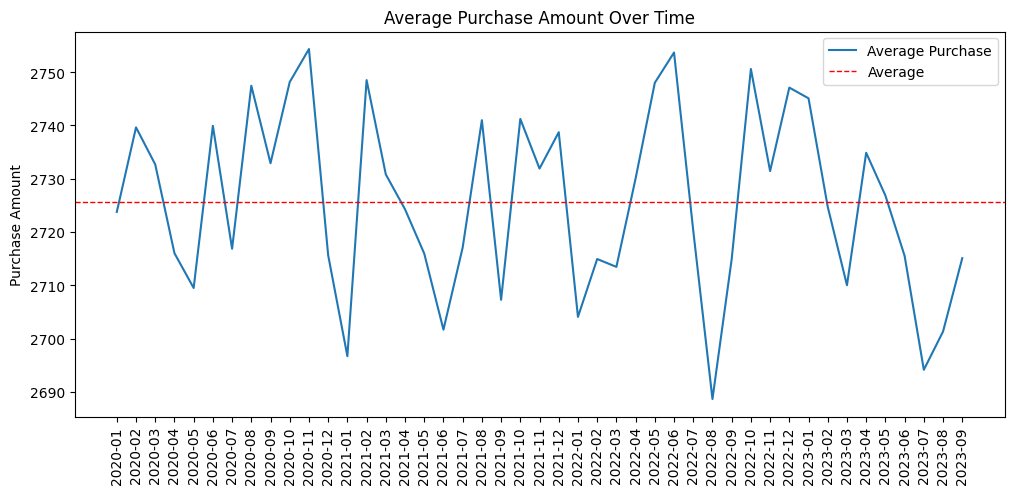

In [23]:
avg_purchase_over_time = df.groupby(df['year_month'])['Total Purchase Amount'].mean()

line_plot(x = avg_purchase_over_time.index, y = avg_purchase_over_time.values, label='Average Purchase', 
          title='Average Purchase Amount Over Time', ylabel='Purchase Amount')

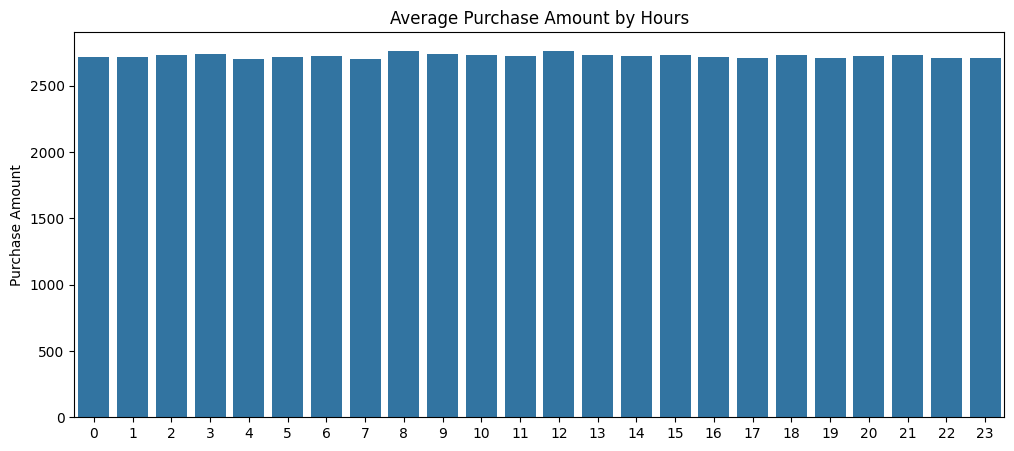

In [24]:
avg_purchase_time = df.groupby('hour')['Total Purchase Amount'].mean()

bar_plot(x=avg_purchase_time.index, y=avg_purchase_time.values, title='Average Purchase Amount by Hours', ylabel='Purchase Amount')

/var/folders/dr/bkbhk3k17yd_fvc3q6mtfkmw0000gn/T/ipykernel_58025/2653658454.py:26: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bars = sns.barplot(x=x, y=y, palette=color)


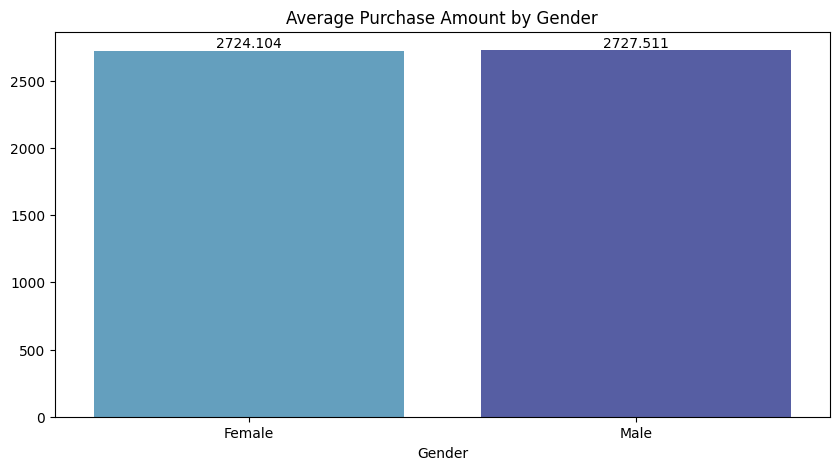

In [25]:
colors=['#ff9999','#66b3ff']
avg_purchase_gender = df.groupby('Gender')['Total Purchase Amount'].mean()

bar_groups(avg_purchase_gender.index, avg_purchase_gender.values, title='Average Purchase Amount by Gender', color= sns.color_palette("icefire"))

/var/folders/dr/bkbhk3k17yd_fvc3q6mtfkmw0000gn/T/ipykernel_58025/2653658454.py:26: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  bars = sns.barplot(x=x, y=y, palette=color)


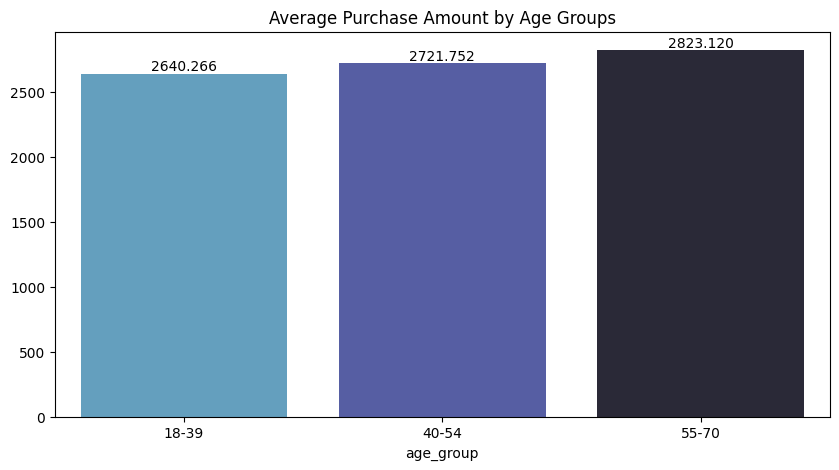

In [26]:
avg_purchase_age = df.groupby('age_group')['Total Purchase Amount'].mean()
bar_groups(x=avg_purchase_age.index, y=avg_purchase_age.values, title='Average Purchase Amount by Age Groups', color = sns.color_palette("icefire"))


#### Total Price

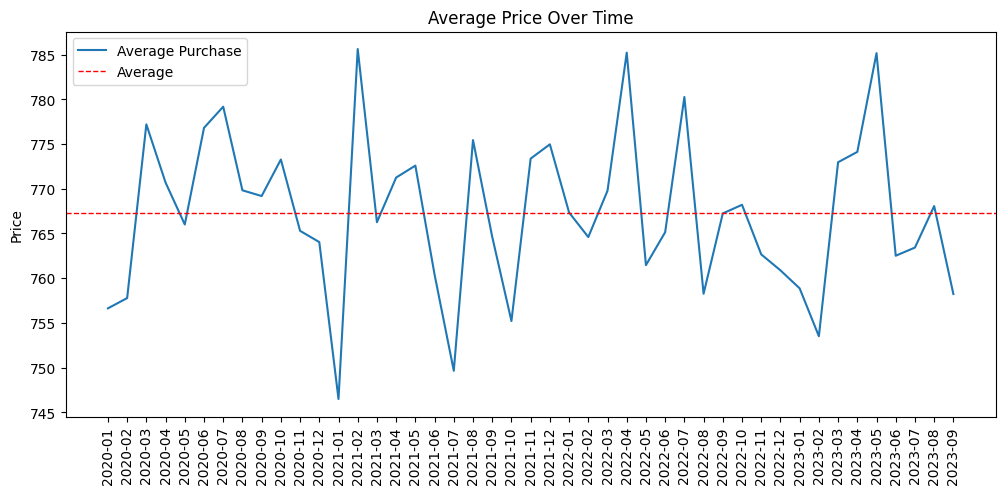

In [27]:
totalprice_over_time = df.groupby(df['year_month'])['total_price'].mean()
line_plot(x = totalprice_over_time.index, y = totalprice_over_time.values, label='Average Purchase', 
          title='Average Price Over Time', ylabel='Price')

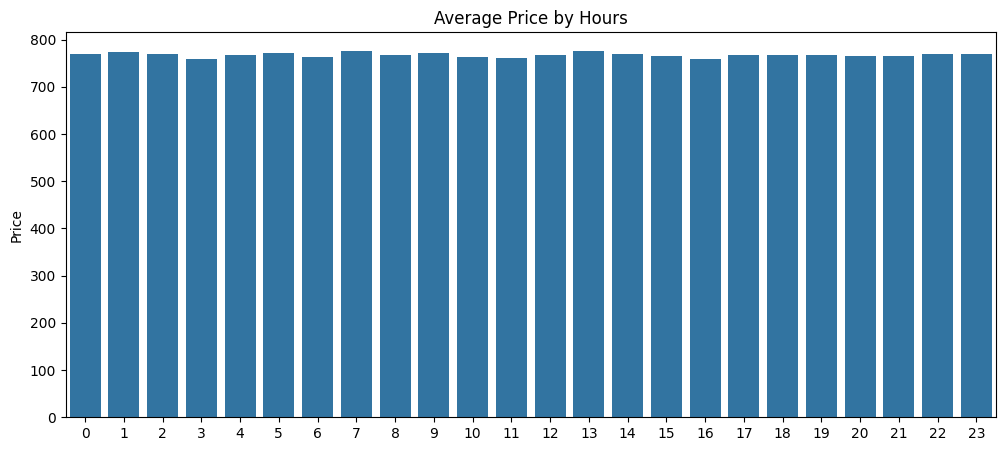

In [28]:
avg_price_time = df.groupby('hour')['total_price'].mean()
bar_plot(x=avg_price_time.index, y=avg_price_time.values, title='Average Price by Hours', ylabel='Price')

/var/folders/dr/bkbhk3k17yd_fvc3q6mtfkmw0000gn/T/ipykernel_58025/2653658454.py:26: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bars = sns.barplot(x=x, y=y, palette=color)


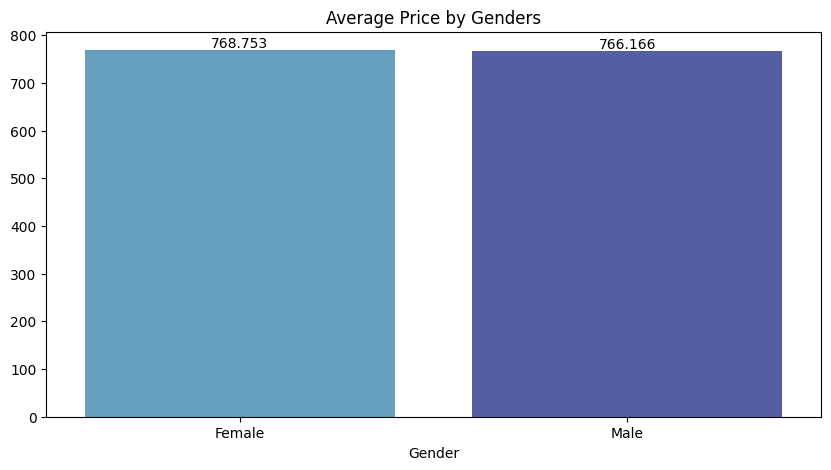

In [29]:
avg_price_gender = df.groupby('Gender')['total_price'].mean()
bar_groups(x=avg_price_gender.index, y=avg_price_gender.values, title='Average Price by Genders', color = sns.color_palette("icefire"))

/var/folders/dr/bkbhk3k17yd_fvc3q6mtfkmw0000gn/T/ipykernel_58025/2653658454.py:26: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  bars = sns.barplot(x=x, y=y, palette=color)


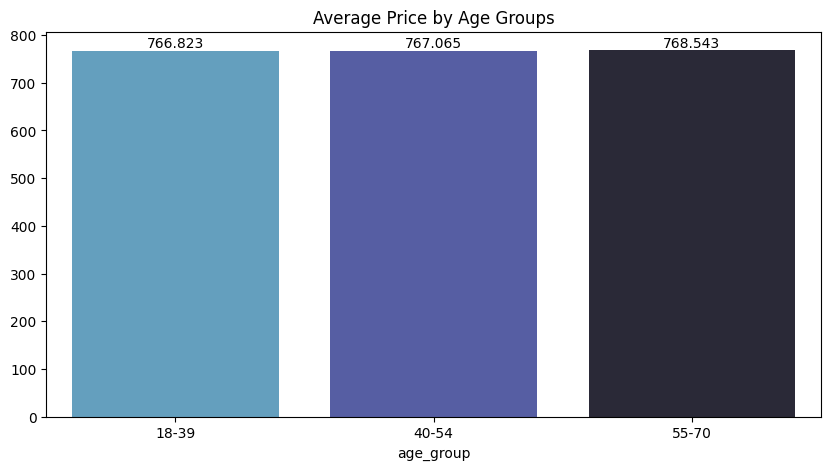

In [30]:
avg_price_age = df.groupby('age_group')['total_price'].mean()
bar_groups(x=avg_price_age.index, y=avg_price_age.values, title='Average Price by Age Groups', color = sns.color_palette("icefire"))


#### Returns

The 'Returns' column indicates whether the customer returned any products from their order, with a binary value: 0 representing no return and 1 representing a return. 

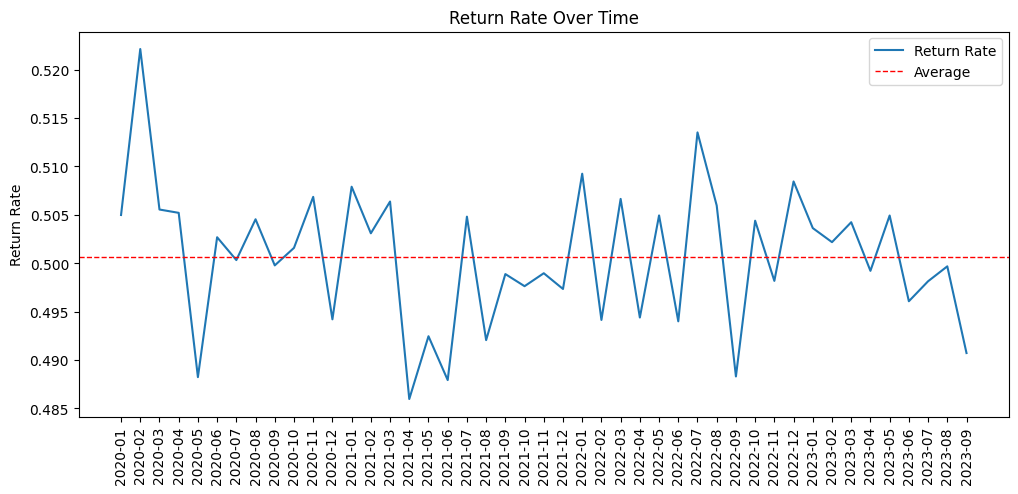

In [31]:
returns = df.groupby('year_month')['Returns'].mean()
line_plot(x = returns.index, y = returns.values, label='Return Rate', 
          title='Return Rate Over Time', ylabel='Return Rate')

/var/folders/dr/bkbhk3k17yd_fvc3q6mtfkmw0000gn/T/ipykernel_58025/2653658454.py:26: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  bars = sns.barplot(x=x, y=y, palette=color)


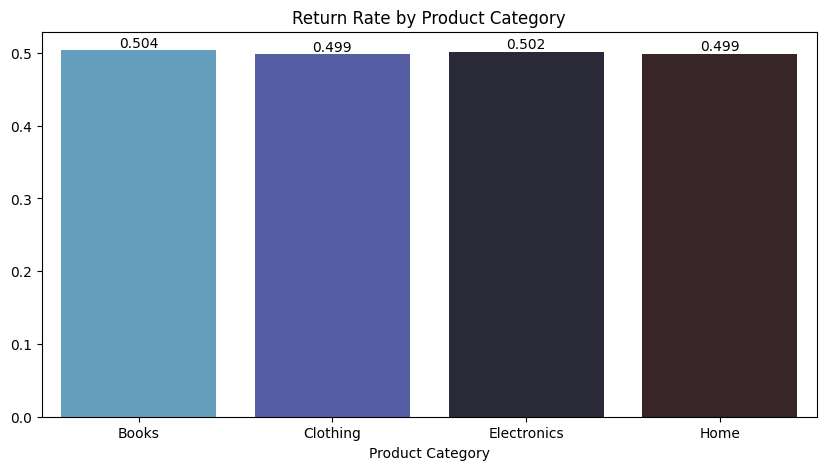

In [32]:
returns_by_products = df.groupby('Product Category')['Returns'].mean()
bar_groups(x=returns_by_products.index, y=returns_by_products.values, title='Return Rate by Product Category', color = sns.color_palette("icefire"))

/var/folders/dr/bkbhk3k17yd_fvc3q6mtfkmw0000gn/T/ipykernel_58025/2653658454.py:26: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bars = sns.barplot(x=x, y=y, palette=color)


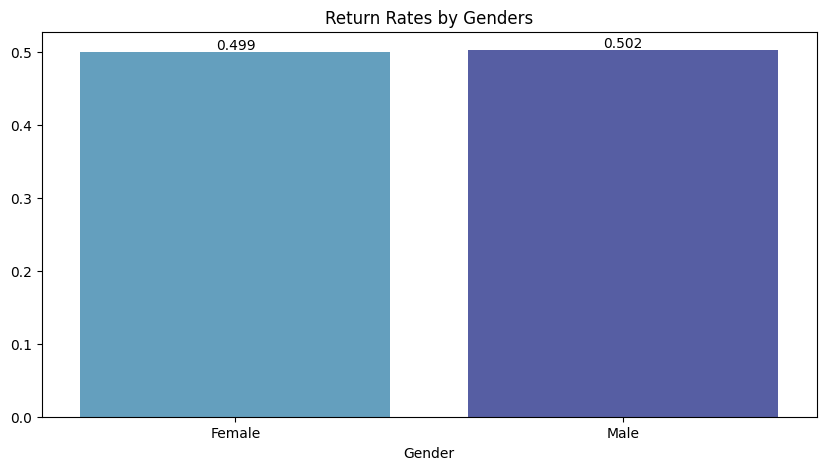

In [33]:
return_gender = df.groupby('Gender')['Returns'].mean()
bar_groups(x=return_gender.index, y=return_gender.values, title='Return Rates by Genders', color = sns.color_palette("icefire"))

/var/folders/dr/bkbhk3k17yd_fvc3q6mtfkmw0000gn/T/ipykernel_58025/2653658454.py:26: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  bars = sns.barplot(x=x, y=y, palette=color)


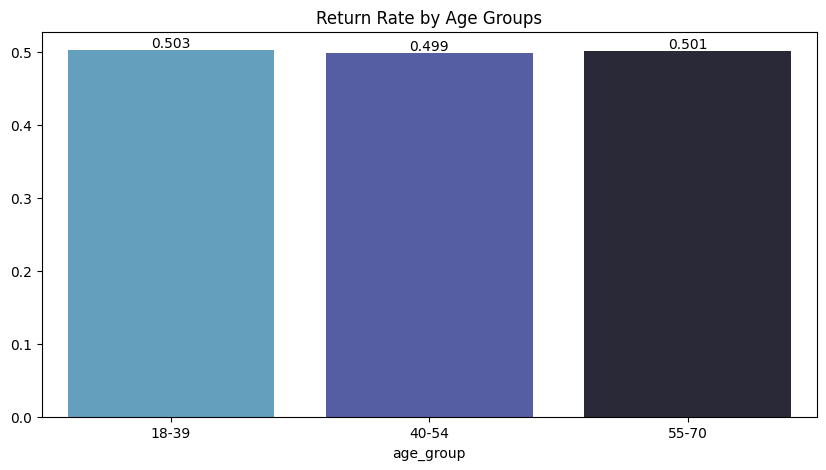

In [34]:
returns_by_agegroups = df.groupby('age_group')['Returns'].mean()
bar_groups(x=returns_by_agegroups.index, y=returns_by_agegroups.values, title='Return Rate by Age Groups', color = sns.color_palette("icefire"))

#### Churn Rate

Most customers have made multiple purchases. To accurately capture churn status, I retained only the rows corresponding to each customer’s latest purchase.

In [35]:
# for example
df[(df['Customer ID'] == 2) | (df['Customer ID'] == 7)][['Customer ID', 'date', 'Churn']]

,Customer ID,date,Churn
225933,2,2023-07-03,0
225937,2,2023-04-26,0
225936,2,2022-09-04,0
225935,2,2022-03-14,0
225932,2,2020-07-31,0
225934,2,2021-08-30,0
28034,7,2022-11-24,1
28032,7,2021-09-21,1
28031,7,2020-04-02,1
28028,7,2022-12-25,1


In [36]:
latest_purchase = df.sort_values('date').drop_duplicates('Customer ID', keep='last').sort_values('Customer ID')
latest_purchase.shape

(49146, 15)

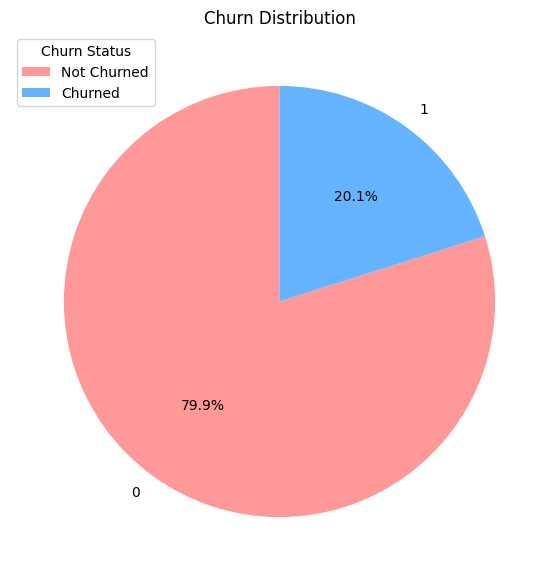

In [37]:
churn_rate = df['Churn'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(churn_rate, labels=churn_rate.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Churn Distribution')
plt.legend(['Not Churned', 'Churned'], title="Churn Status")
plt.show()

/var/folders/dr/bkbhk3k17yd_fvc3q6mtfkmw0000gn/T/ipykernel_58025/2653658454.py:26: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bars = sns.barplot(x=x, y=y, palette=color)


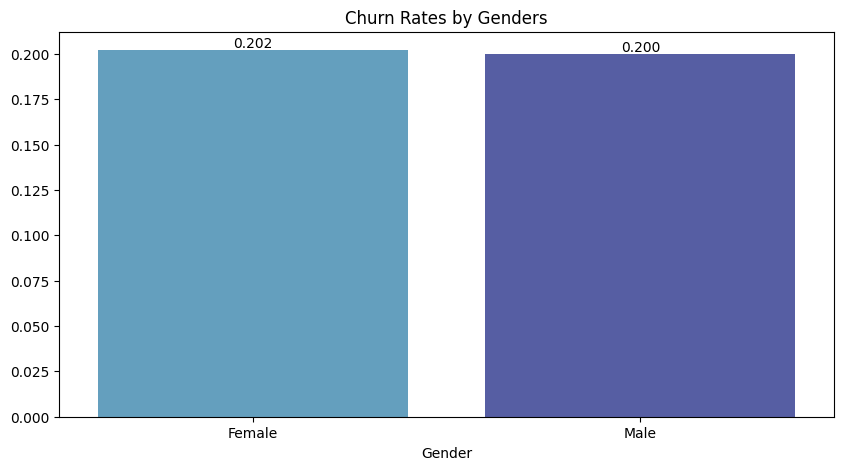

In [38]:
churnrate_by_gender = df.groupby('Gender')['Churn'].mean()
bar_groups(x=churnrate_by_gender.index, y=churnrate_by_gender.values, title='Churn Rates by Genders', color = sns.color_palette("icefire"))

/var/folders/dr/bkbhk3k17yd_fvc3q6mtfkmw0000gn/T/ipykernel_58025/2653658454.py:26: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  bars = sns.barplot(x=x, y=y, palette=color)


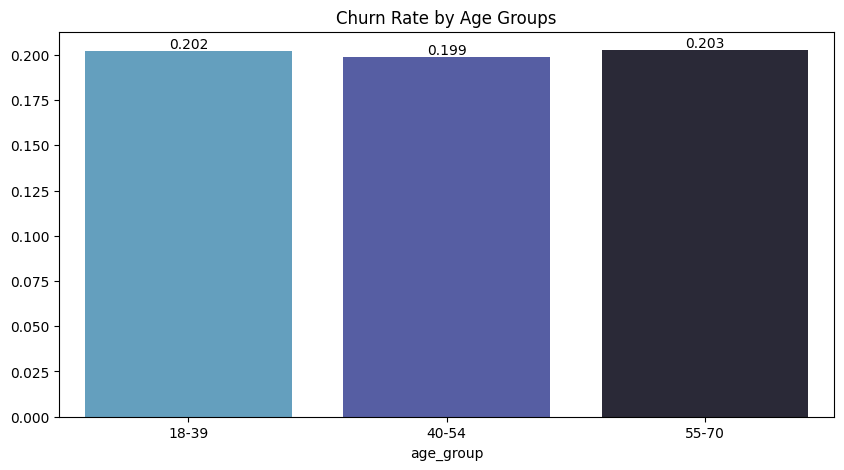

In [39]:
churnrate_by_agegroups = df.groupby('age_group')['Churn'].mean()
bar_groups(x=churnrate_by_agegroups.index, y=churnrate_by_agegroups.values, title='Churn Rate by Age Groups', color = sns.color_palette("icefire"))

### 2) Survival Analysis

#### Data Prep

First, I calculate the tenure of each customer.

In [40]:
customer_tenure = df.groupby('Customer ID')['date'].agg(['min', 'max']).reset_index()
customer_tenure['min'] = pd.to_datetime(customer_tenure['min'])
customer_tenure['max'] = pd.to_datetime(customer_tenure['max'])
#customer_tenure['tenure'] = (customer_tenure['max'] - customer_tenure['min']).dt.days
def calculate_months(row):
    delta = relativedelta(row['max'], row['min'])
    return delta.years * 12 + delta.months

customer_tenure['tenure'] = customer_tenure.apply(calculate_months, axis=1)
customer_tenure = customer_tenure.drop(['min', 'max'], axis=1)
customer_tenure

,Customer ID,tenure
0,1,0
1,2,35
2,3,0
3,4,20
4,5,21
...,...,...
49141,49996,24
49142,49997,12
49143,49998,39
49144,49999,25


If tenure is 0, the customer made purchase once.

In [41]:
(customer_tenure[customer_tenure['tenure'] == 0]).shape

(3746, 2)

There are 3,428 customers who have made only one purchase. Next, I will add other variables, such as churn, gender, total purchase amount and total price.

In [42]:
customer_info = df.groupby('Customer ID')[['Age', 'Gender', 'Churn']].first().reset_index()
customer_info = customer_info.merge(customer_tenure, how='left', on = 'Customer ID')
customer_info['Gender'] = customer_info['Gender'].replace({'Male':0, 'Female':1})
customer_info

,Customer ID,Age,Gender,Churn,tenure
0,1,67,1,0,0
1,2,42,1,0,35
2,3,31,0,0,0
3,4,37,0,0,20
4,5,24,1,0,21
...,...,...,...,...,...
49141,49996,45,1,0,24
49142,49997,65,0,0,12
49143,49998,31,1,1,39
49144,49999,70,1,0,25


In [43]:
purchase_return = df.groupby('Customer ID').agg({'Total Purchase Amount': 'sum', 'Returns':'mean'}).reset_index()
customer_info = customer_info.merge(purchase_return, how = 'left', on = 'Customer ID')
category_quantity = df.groupby(['Customer ID', 'Product Category'])['Quantity'].sum().unstack(fill_value=0).reset_index()
category_quantity.columns = [col if col == 'Customer ID' else f"{col}_quant" for col in category_quantity.columns]
customer_info = customer_info.merge(category_quantity, how = 'left', on = 'Customer ID')
customer_info

,Customer ID,Age,Gender,Churn,tenure,Total Purchase Amount,Returns,Books_quant,Clothing_quant,Electronics_quant,Home_quant
0,1,67,1,0,0,5148,0.000000,5,0,0,0
1,2,42,1,0,35,16481,0.666667,1,2,11,4
2,3,31,0,0,0,4687,0.000000,0,0,3,0
3,4,37,0,0,20,7826,0.600000,8,5,3,3
4,5,24,1,0,21,7681,1.000000,5,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
49141,49996,45,1,0,24,21762,0.333333,13,0,0,7
49142,49997,65,0,0,12,5714,0.000000,0,4,4,0
49143,49998,31,1,1,39,20495,0.600000,18,5,7,0
49144,49999,70,1,0,25,12709,0.600000,9,3,1,2


In [44]:
total_price = df.groupby('Customer ID')['total_price'].sum().reset_index()
customer_info = customer_info.merge(total_price, how = 'left', on = 'Customer ID')
customer_info

,Customer ID,Age,Gender,Churn,tenure,Total Purchase Amount,Returns,Books_quant,Clothing_quant,Electronics_quant,Home_quant,total_price
0,1,67,1,0,0,5148,0.000000,5,0,0,0,2280
1,2,42,1,0,35,16481,0.666667,1,2,11,4,6459
2,3,31,0,0,0,4687,0.000000,0,0,3,0,564
3,4,37,0,0,20,7826,0.600000,8,5,3,3,4339
4,5,24,1,0,21,7681,1.000000,5,0,0,3,1230
...,...,...,...,...,...,...,...,...,...,...,...,...
49141,49996,45,1,0,24,21762,0.333333,13,0,0,7,5872
49142,49997,65,0,0,12,5714,0.000000,0,4,4,0,1592
49143,49998,31,1,1,39,20495,0.600000,18,5,7,0,8440
49144,49999,70,1,0,25,12709,0.600000,9,3,1,2,2408


In [45]:
df_grouped = df.groupby(['Customer ID'])['Payment Method'].apply(lambda x: ', '.join(sorted(set(x)))).reset_index()
df_grouped = df_grouped.rename(columns={'Payment Method': 'Payment_Method'})
customer_info = customer_info.merge(df_grouped, how = 'left', on='Customer ID')

In [46]:
df_survival = customer_info.drop('Customer ID', axis = 1)

In [47]:
df_survival = df_survival.rename(columns={'Total Purchase Amount': 'total_purchase'})
df_survival['total_purchase'] = np.log1p(df_survival['total_purchase'])
df_survival['total_price'] = np.log1p(df_survival['total_price'])
df_survival['age_group'] = pd.qcut(df_survival['Age'], q=3, labels=['18-39', '40-54', '55-70'])
df_survival

,Age,Gender,Churn,tenure,total_purchase,Returns,Books_quant,Clothing_quant,Electronics_quant,Home_quant,total_price,Payment_Method,age_group
0,67,1,0,0,8.546558,0.000000,5,0,0,0,7.732369,Credit Card,55-70
1,42,1,0,35,9.710024,0.666667,1,2,11,4,8.773385,"Cash, Credit Card, PayPal",40-54
2,31,0,0,0,8.452761,0.000000,0,0,3,0,6.336826,Cash,18-39
3,37,0,0,20,8.965335,0.600000,8,5,3,3,8.375630,"Cash, Credit Card, PayPal",40-54
4,24,1,0,21,8.946635,1.000000,5,0,0,3,7.115582,"Cash, Credit Card, PayPal",18-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49141,45,1,0,24,9.987967,0.333333,13,0,0,7,8.678121,"Cash, PayPal",40-54
49142,65,0,0,12,8.650850,0.000000,0,4,4,0,7.373374,"Cash, PayPal",55-70
49143,31,1,1,39,9.927985,0.600000,18,5,7,0,9.040856,"Cash, Credit Card, PayPal",18-39
49144,70,1,0,25,9.450144,0.600000,9,3,1,2,7.786967,"Cash, Credit Card, PayPal",55-70


In [48]:
df_survival.columns

Index(['Age', 'Gender', 'Churn', 'tenure', 'total_purchase', 'Returns',
       'Books_quant', 'Clothing_quant', 'Electronics_quant', 'Home_quant',
       'total_price', 'Payment_Method', 'age_group'],
      dtype='object')

#### Survival Analysis

First, the Kaplan-Meier curve will be drawn for all customers to analyze the overall customer churn rate over time. Then, this curve will be plotted for different age groups, genders, and payment methods to understand how these factors influence customer retention and churn patterns.

##### Kaplan-Meier

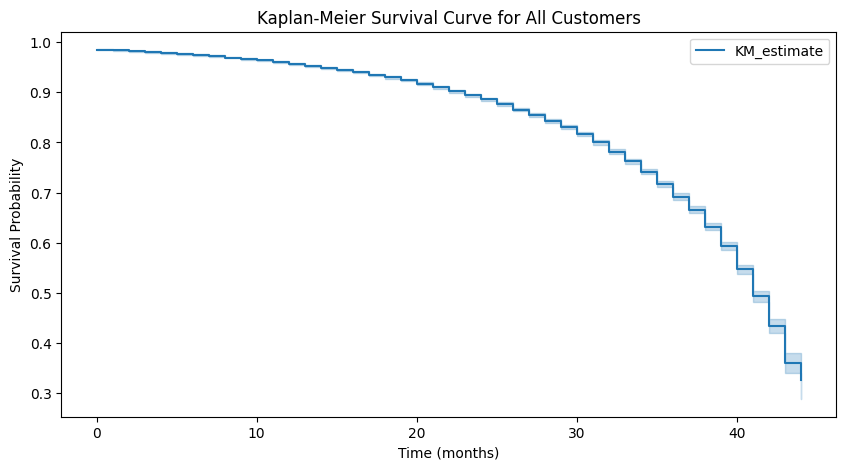

In [49]:
kmf = KaplanMeierFitter()
kmf.fit(df_survival['tenure'], event_observed=df_survival['Churn'])
plt.figure(figsize=(10,5))
kmf.plot()
plt.title('Kaplan-Meier Survival Curve for All Customers')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.show()

Based on the curve above, the survival probability of customers decreases over time, and the decline becomes faster as time progresses. In other words, the change in probability around the 40th month is greater than that in the 10th month. In the early months, the decline is slower, but in later months (e.g., around the 40th month), customer churn increases at a faster rate.

In [50]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,0.985085
1.0,0.983697
2.0,0.982255
3.0,0.980451
4.0,0.978656
5.0,0.976333
6.0,0.974395
7.0,0.972145
8.0,0.969227


In [51]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,3746,733,3013,49146,49146
1.0,354,64,290,0,45400
2.0,398,66,332,0,45046
3.0,414,82,332,0,44648
4.0,415,81,334,0,44234
5.0,490,104,386,0,43819
6.0,467,86,381,0,43329
7.0,551,99,452,0,42862
8.0,626,127,499,0,42311


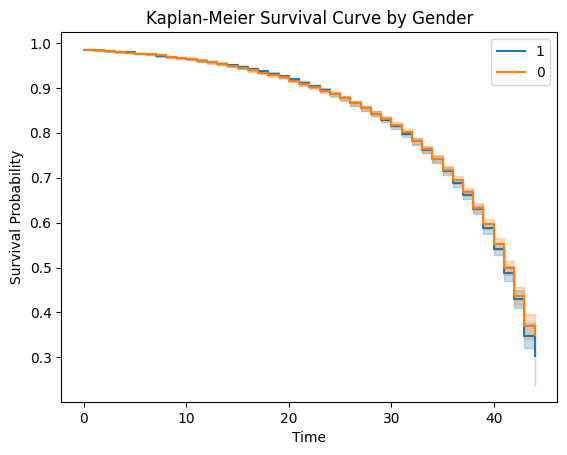

In [52]:
for gender in df_survival['Gender'].unique():
    mask = df_survival['Gender'] == gender
    kmf.fit(df_survival[mask]['tenure'], event_observed=df_survival[mask]['Churn'], label=str(gender))
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Gender')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

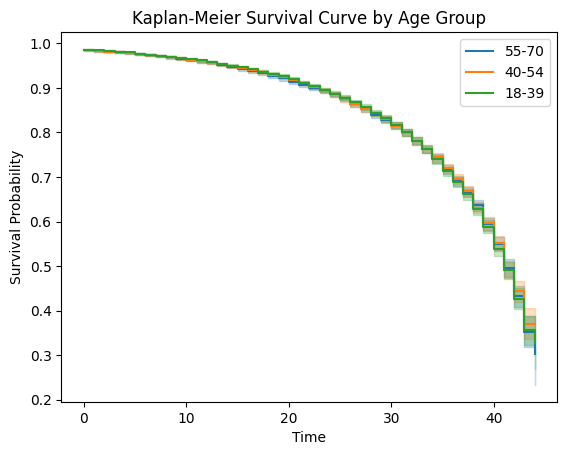

In [53]:
for age in df_survival['age_group'].unique():
    mask = df_survival['age_group'] == age
    kmf.fit(df_survival[mask]['tenure'], event_observed=df_survival[mask]['Churn'], label=str(age))
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Age Group')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

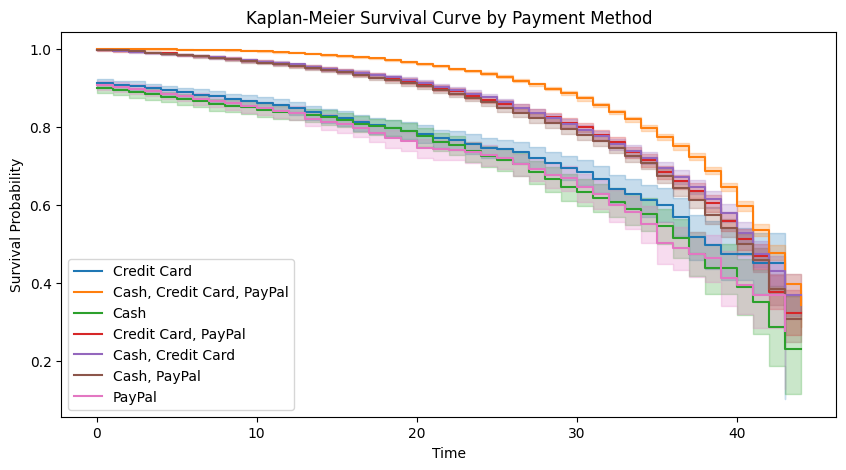

In [54]:
plt.figure(figsize=(10,5))
for payment in df_survival['Payment_Method'].unique():
    mask = df_survival['Payment_Method'] == payment
    kmf.fit(df_survival[mask]['tenure'], event_observed=df_survival[mask]['Churn'], label=str(payment))
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Payment Method')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

There is no significant difference in survival rates across different genders and age groups, but survival probabilities vary among different payment methods. In other words, while gender and age do not seem to impact customer churn rates, different payment methods are associated with different churn probabilities. This suggests that payment methods may influence customer retention, with certain methods potentially leading to lower churn or higher loyalty.

To see this effect of payment methods, I will implement the Log Rank Tests. But I will categorize payment methods into 3 categories such as single payment, two payments and all payments.  

Single payment method: "Credit Card", "Cash", "PayPal"

Two payment methods: "Cash, Credit Card", "Credit Card, PayPal", etc.

The group where all three payment methods: "Cash, Credit Card, PayPal"

In [55]:
df_survival['payment_method_category'] = df_survival['Payment_Method'].apply(
    lambda x: 'Single payment' if ',' not in x else ('Two payments' if x.count(',') == 1 else 'All payments'))

df_survival


,Age,Gender,Churn,tenure,total_purchase,Returns,Books_quant,Clothing_quant,Electronics_quant,Home_quant,total_price,Payment_Method,age_group,payment_method_category
0,67,1,0,0,8.546558,0.000000,5,0,0,0,7.732369,Credit Card,55-70,Single payment
1,42,1,0,35,9.710024,0.666667,1,2,11,4,8.773385,"Cash, Credit Card, PayPal",40-54,All payments
2,31,0,0,0,8.452761,0.000000,0,0,3,0,6.336826,Cash,18-39,Single payment
3,37,0,0,20,8.965335,0.600000,8,5,3,3,8.375630,"Cash, Credit Card, PayPal",40-54,All payments
4,24,1,0,21,8.946635,1.000000,5,0,0,3,7.115582,"Cash, Credit Card, PayPal",18-39,All payments
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49141,45,1,0,24,9.987967,0.333333,13,0,0,7,8.678121,"Cash, PayPal",40-54,Two payments
49142,65,0,0,12,8.650850,0.000000,0,4,4,0,7.373374,"Cash, PayPal",55-70,Two payments
49143,31,1,1,39,9.927985,0.600000,18,5,7,0,9.040856,"Cash, Credit Card, PayPal",18-39,All payments
49144,70,1,0,25,9.450144,0.600000,9,3,1,2,7.786967,"Cash, Credit Card, PayPal",55-70,All payments


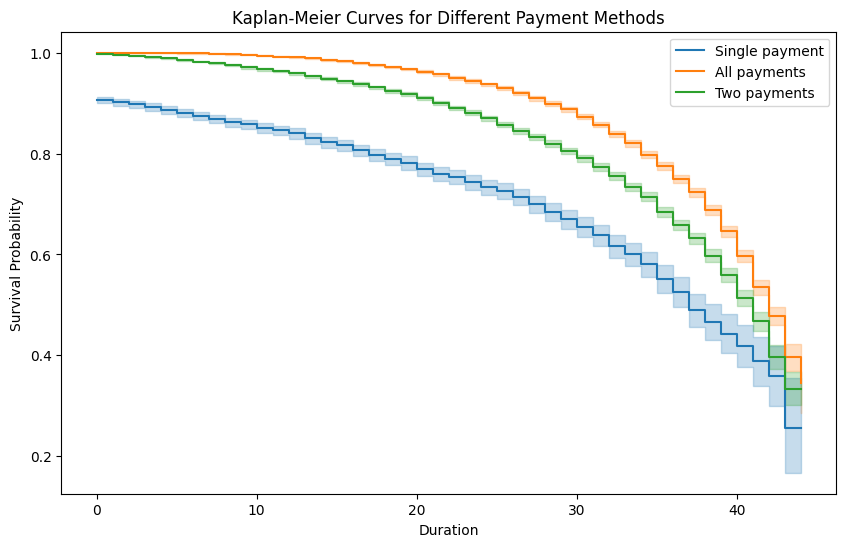

In [56]:
plt.figure(figsize=(10, 6))
for category in df_survival['payment_method_category'].unique():
    group_data = df_survival[df_survival['payment_method_category'] == category]
    kmf.fit(group_data['tenure'], event_observed=group_data['Churn'], label=category)
    kmf.plot()

plt.title("Kaplan-Meier Curves for Different Payment Methods")
plt.xlabel("Duration")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

In [57]:
categories = df_survival['payment_method_category'].unique()
logrank_results = {}

for cat1, cat2 in itertools.combinations(categories, 2):
    group1 = df_survival[df_survival['payment_method_category'] == cat1]
    group2 = df_survival[df_survival['payment_method_category'] == cat2]
    
    results = logrank_test(group1['tenure'], group2['tenure'], 
                           event_observed_A=group1['Churn'], event_observed_B=group2['Churn'])
    
    logrank_results[f'{cat1} vs {cat2}'] = results.p_value

In [58]:
logrank_results

{'Single payment vs All payments': 0.0,
 'Single payment vs Two payments': 6.023312461062365e-180,
 'All payments vs Two payments': 5.298356697403254e-88}

These Log Rank test results show that there are significant differences in the survival curves between the payment method categories. It means the payment method plays a crucial role in determining customer retention.

##### Cox’s proportional hazard model

In [59]:
df_survival = df_survival.drop(['age_group', 'Payment_Method', 'Gender', 'Age'], axis =1)

In [60]:
df_survival = pd.get_dummies(df_survival, columns=['payment_method_category'])
df_survival

,Churn,tenure,total_purchase,Returns,Books_quant,Clothing_quant,Electronics_quant,Home_quant,total_price,payment_method_category_All payments,payment_method_category_Single payment,payment_method_category_Two payments
0,0,0,8.546558,0.000000,5,0,0,0,7.732369,False,True,False
1,0,35,9.710024,0.666667,1,2,11,4,8.773385,True,False,False
2,0,0,8.452761,0.000000,0,0,3,0,6.336826,False,True,False
3,0,20,8.965335,0.600000,8,5,3,3,8.375630,True,False,False
4,0,21,8.946635,1.000000,5,0,0,3,7.115582,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
49141,0,24,9.987967,0.333333,13,0,0,7,8.678121,False,False,True
49142,0,12,8.650850,0.000000,0,4,4,0,7.373374,False,False,True
49143,1,39,9.927985,0.600000,18,5,7,0,9.040856,True,False,False
49144,0,25,9.450144,0.600000,9,3,1,2,7.786967,True,False,False


In [61]:
cox_model = CoxPHFitter(penalizer=0.1)
cox_model.fit(df_survival, duration_col='tenure', event_col='Churn')

<lifelines.CoxPHFitter: fitted with 49146 total observations, 39328 right-censored observations>

In [62]:
cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 49146 total observations, 39328 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 49146
number of events observed = 9818
   partial log-likelihood = -95422.81
         time fit was run = 2024-11-14 21:43:32 UTC

---
                                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                               
total_purchase                         -0.31      0.74      0.02           -0.33           -0.28                0.72                0.76
Returns                                -0.06      0.94      0.03           -0.12            0.00                0.89                1.00
Books_quant                            -0.02      0.98      0.00           -0.03           -0.02                0.97                0.98
Clothing_quant                         -0.02      0.98      0.00           -0.03           -0.02                0.97                0.98
Electronics_quant                      -0.02      0.98      0.00           -0.03           -0.02                0.97                0.98
Home_quant                             -0.02      0.98      0.00           -0.03           -0.02                0.97                0.98
total_price                            -0.17      0.84      0.01           -0.20           -0.15                0.82                0.86
payment_method_category_All payments   -0.15      0.86      0.02           -0.19           -0.11                0.83                0.90
payment_method_category_Single payment  0.38      1.46      0.03            0.33            0.44                1.38                1.55
payment_method_category_Two payments   -0.05      0.95      0.02           -0.09           -0.01                0.91                0.99

                                        cmp to      z      p  -log2(p)
covariate                                                             
total_purchase                            0.00 -19.99 <0.005    292.93
Returns                                   0.00  -1.85   0.06      3.97
Books_quant                               0.00  -7.94 <0.005     48.80
Clothing_quant                            0.00  -7.90 <0.005     48.31
Electronics_quant                         0.00  -8.65 <0.005     57.45
Home_quant                                0.00  -7.98 <0.005     49.28
total_price                               0.00 -13.31 <0.005    131.82
payment_method_category_All payments      0.00  -6.79 <0.005     36.42
payment_method_category_Single payment    0.00  13.58 <0.005    137.08
payment_method_category_Two payments      0.00  -2.52   0.01      6.40
---
Concordance = 0.70
Partial AIC = 190865.62
log-likelihood ratio test = 2465.75 on 10 df
-log2(p) of ll-ratio test = inf

The C-index (Concordance Index) is 0.70, which means the model has a moderate predictive performance

<Axes: xlabel='log(HR) (95% CI)'>

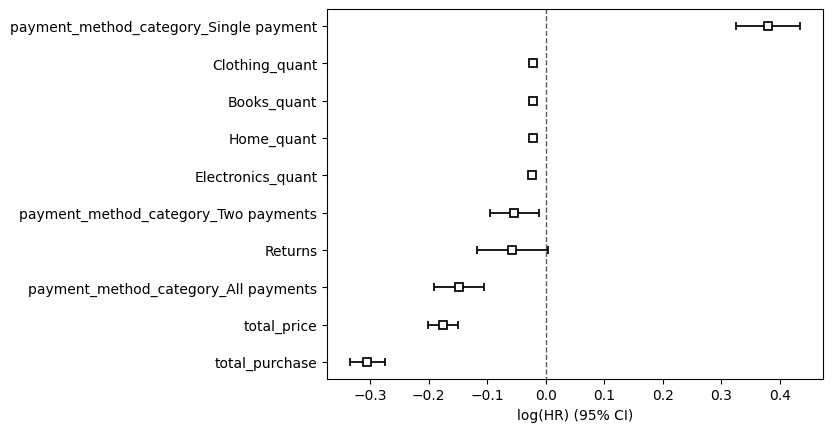

In [63]:
cox_model.plot()

In [64]:
cox_model.hazard_ratios_

covariate
total_purchase                            0.737111
Returns                                   0.944749
Books_quant                               0.979256
Clothing_quant                            0.979540
Electronics_quant                         0.977494
Home_quant                                0.979209
total_price                               0.839906
payment_method_category_All payments      0.862445
payment_method_category_Single payment    1.462874
payment_method_category_Two payments      0.948046
Name: exp(coef), dtype: float64

The hazard ratios for total purchase, total price, and quantities of items being less than 1 indicates that as these values increase, the risk of 
churn decreases. This means that customers who spend more (either through higher total purchases or larger quantities in specific categories) are less likely to churn.

Single payment has a hazard ratio greater than 1, indicating that customers using this payment method have a higher likelihood of churning, by 46.3%. All payments and Two payments have hazard ratios less than 1, indicating that these payment methods are associated with a lower risk of churn. In other words, customers who use multiple payment methods are less likely to churn.

In conclusion, strategies focused on increasing purchases and encouraging customers to use more diverse payment methods may help reduce customer churn effectively.

In [65]:
cox_model.predict_median(df_survival)

0        33.0
1        43.0
2        31.0
3        42.0
4        39.0
         ... 
49141    43.0
49142    38.0
49143     inf
49144    42.0
49145    43.0
Name: 0.5, Length: 49146, dtype: float64

### Customer LTV

Customer Lifetime Value (CLTV) is an important metric for businesses of all sizes, as it helps to estimate the total value a customer will bring to the company over their entire lifetime

First, I need to prepare RFM (Recency, Frequency, Monetary) dataset.

**Recency**: The age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. 

**Frequency**: The count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

**Monetary Value**: This is equal to the sum of all a customer’s purchases divided by the total number of purchases. 

**T**: The duration between a customer’s first purchase and the end of the period under study.

In [66]:
df_cltv = df[['Customer ID', 'Product Price', 'Quantity', 'date']].reset_index()
df_cltv = df_cltv.rename(columns={'Customer ID': 'id', 'Product Price': 'price', 'Quantity': 'quant'})
df_cltv['total_purchase'] = df_cltv['quant'] * df_cltv['price']
df_cltv

,index,id,price,quant,date,total_purchase
0,160921,1,456,5,2021-04-08,2280
1,225933,2,190,1,2023-07-03,190
2,225937,2,461,5,2023-04-26,2305
3,225936,2,227,4,2022-09-04,908
4,225935,2,376,4,2022-03-14,1504
...,...,...,...,...,...,...
202613,23862,50000,107,3,2020-10-04,321
202614,23866,50000,308,1,2020-03-11,308
202615,23864,50000,406,1,2023-05-14,406
202616,23860,50000,409,2,2020-01-17,818


In [67]:
df_cltv['date'] = pd.to_datetime(df_cltv['date'])
snapshot_date = df_cltv['date'].max() + pd.Timedelta(days=2)
snapshot_date

Timestamp('2023-09-15 00:00:00')

In [68]:
df_cltv_last = df_cltv.groupby('id').agg(
    T=('date', lambda x: (snapshot_date - x.min()).days),
    recency = ('date', lambda x: (x.max() - x.min()).days),
    frequency=('date', 'count'),
    monetary=('total_purchase', 'mean')
).reset_index()
df_cltv_last

,id,T,recency,frequency,monetary
0,1,890,0,1,2280.000000
1,2,1141,1067,6,1076.500000
2,3,224,0,1,564.000000
3,4,1068,625,5,867.800000
4,5,1179,640,3,410.000000
...,...,...,...,...,...
49141,49996,1105,744,6,978.666667
49142,49997,785,395,2,796.000000
49143,49998,1232,1217,10,844.000000
49144,49999,1149,791,5,481.600000


#### BG/NBD model

This model is used for predicting the expected number of transactions for each customer.

In [69]:
bgf = BetaGeoFitter(penalizer_coef=0.0001)  
bgf.fit(df_cltv_last['frequency'], df_cltv_last['recency'], df_cltv_last['T'])

<lifetimes.BetaGeoFitter: fitted with 49146 subjects, a: 0.53, alpha: 3199.32, b: 7.22, r: 14.77>

In [70]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,14.768844,0.181013,14.414058,15.123629
alpha,3199.323664,41.009369,3118.945301,3279.702027
a,0.529321,0.016486,0.497009,0.561633
b,7.217762,0.197340,6.830975,7.604548


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

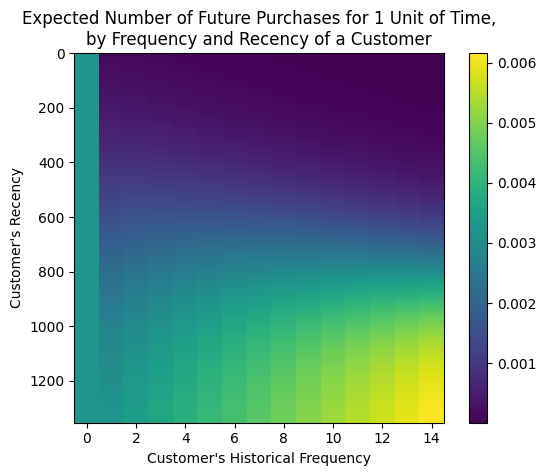

In [71]:
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

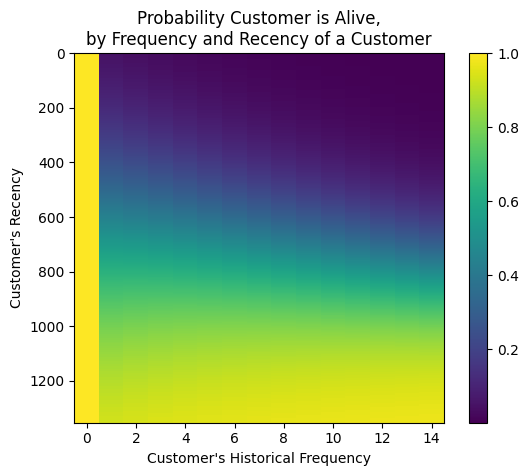

In [72]:
plot_probability_alive_matrix(bgf)

In [73]:
t = 365
df_cltv_last['expected_purc_1_year'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df_cltv_last['frequency'], df_cltv_last['recency'], df_cltv_last['T'])
df_cltv_last.sort_values(by='expected_purc_1_year').tail(10)

,id,T,recency,frequency,monetary,expected_purc_1_year
21137,21489,912,881,11,498.454545,2.135720
12942,13159,1060,1020,12,649.000000,2.144686
45842,46629,1166,1075,13,581.153846,2.148275
33545,34120,1083,1080,12,411.666667,2.149663
22303,22670,688,684,10,887.300000,2.174252
32581,33138,997,993,12,723.500000,2.191981
5412,5498,622,607,10,825.100000,2.205226
13578,13805,1223,1196,14,694.714286,2.237376
25987,26422,973,887,13,602.076923,2.245416
44334,45098,872,780,14,691.500000,2.379953


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

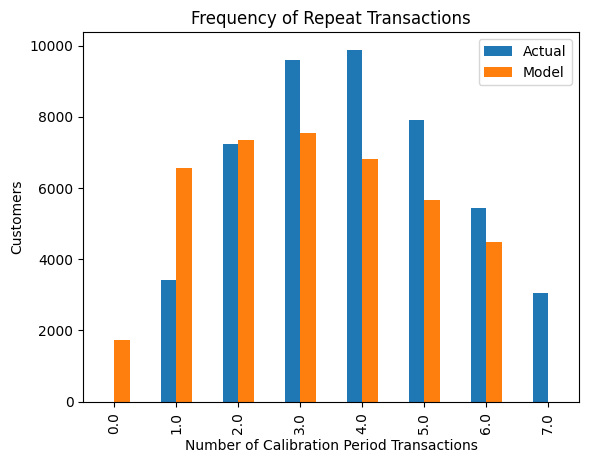

In [74]:
plot_period_transactions(bgf)

After predicting the expected number of purchases of each customer. We need to predict monetary value in order to predict CLTV.

#### Gamma-Gamma model

In [75]:
df_cltv_last[['frequency','monetary']].corr()

,frequency,monetary
frequency,1.000000,0.003222
monetary,0.003222,1.000000


The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. The correlation displayed above is very close to 0. So, I can use the gamma-gamma model.

In [76]:
ggf = GammaGammaFitter(penalizer_coef = 0.0001)
ggf.fit(df_cltv_last['frequency'],
        df_cltv_last['monetary'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 49146 subjects, p: 31.44, q: 1.97, v: 32.94>


In [77]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        df_cltv_last['frequency'],
        df_cltv_last['monetary']
    ).mean(),
    df_cltv_last[df_cltv_last['frequency']>0]['monetary'].mean()
))

Expected conditional average profit: 769.8867303944623, Average profit: 766.940925513261


#### CLTV

In [78]:
cltv = ggf.customer_lifetime_value(
    bgf,  
    df_cltv_last['frequency'],
    df_cltv_last['recency'],
    df_cltv_last['T'],
    df_cltv_last['monetary'],
    time=365, # one year  
    discount_rate=0.00035  # Daily discount rate
)

df_cltv_pred = df_cltv_last[['id']].copy()
df_cltv_pred['CLTV'] = cltv

df_cltv_sorted = df_cltv_pred.sort_values(by='CLTV', ascending=False)

print(df_cltv_sorted.head(10))


          id          CLTV
11817  12017  55158.364586
12309  12517  54833.086818
16829  17113  53880.774639
11172  11357  51777.804646
48427  49269  51581.951110
28621  29103  50699.151209
27184  27639  50549.440722
18092  18387  50002.236687
28433  28914  49948.142550
39909  40598  49947.513564


### Customer Segmentation

Customer segmentation based RFM analysis and CLTV prediction.

In [79]:
seg_cltv = df_cltv_last.merge(df_cltv_pred, how='left', on='id')
seg_cltv

,id,T,recency,frequency,monetary,expected_purc_1_year,CLTV
0,1,890,0,1,2280.000000,0.298552,10991.425991
1,2,1141,1067,6,1076.500000,1.590303,30157.752687
2,3,224,0,1,564.000000,1.317534,11913.473372
3,4,1068,625,5,867.800000,1.156224,17485.169379
4,5,1179,640,3,410.000000,0.896562,6418.070645
...,...,...,...,...,...,...,...
49141,49996,1105,744,6,978.666667,1.343475,23123.729175
49142,49997,785,395,2,796.000000,1.081440,14313.097228
49143,49998,1232,1217,10,844.000000,1.911347,29263.565837
49144,49999,1149,791,5,481.600000,1.274422,10812.996037


In [80]:
seg_cltv.columns

Index(['id', 'T', 'recency', 'frequency', 'monetary', 'expected_purc_1_year',
       'CLTV'],
      dtype='object')

In [81]:
features = ['T', 'recency', 'frequency', 'monetary', 'expected_purc_1_year', 'CLTV']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(seg_cltv[features])


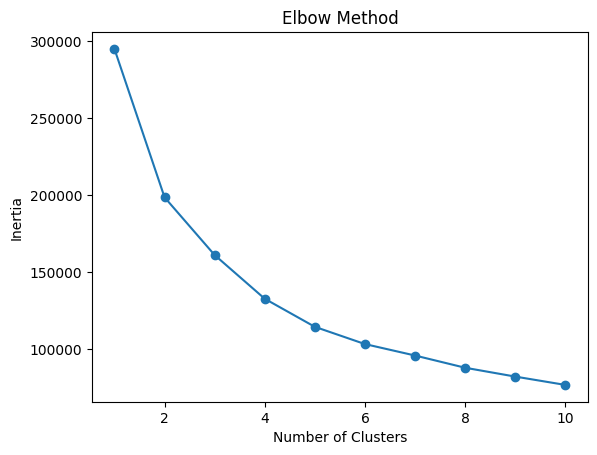

In [82]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [83]:
data_seg = seg_cltv[['frequency', 'monetary', 'CLTV']]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_seg)

In [84]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_scaled)

seg_cltv['Segment'] = kmeans.labels_

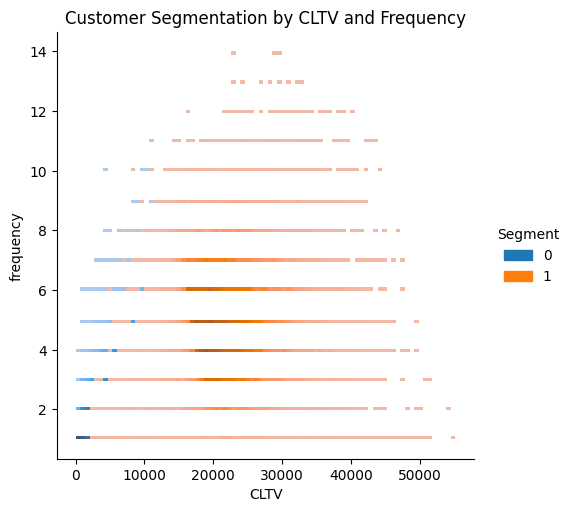

In [85]:
sns.displot(data=seg_cltv, x='CLTV', y='frequency', hue='Segment')
plt.title('Customer Segmentation by CLTV and Frequency')
plt.show()

In [86]:
segment_analysis = seg_cltv.groupby('Segment').mean()
print(segment_analysis)

                   id            T     recency  frequency    monetary  \
Segment                                                                 
0        24932.650285  1018.572238  608.079644   3.289712  560.871004   
1        25048.715151  1070.613935  859.635681   4.988754  981.152050   

         expected_purc_1_year          CLTV  
Segment                                      
0                    1.055604   9709.765965  
1                    1.402062  23082.339638  


In [87]:
number_of_customer = seg_cltv.groupby('Segment')['id'].count()
number_of_customer

Segment
0    25049
1    24097
Name: id, dtype: int64

Loyal Customers, Almost Lost Customers and Lost Customers(Churned)

In [88]:
churn_data = customer_info[['Customer ID', 'Churn']]
seg_cltv = seg_cltv.merge(churn_data, how='left', left_on='id', right_on='Customer ID')
seg_cltv

,id,T,recency,frequency,monetary,expected_purc_1_year,CLTV,Segment,Customer ID,Churn
0,1,890,0,1,2280.000000,0.298552,10991.425991,1,1,0
1,2,1141,1067,6,1076.500000,1.590303,30157.752687,1,2,0
2,3,224,0,1,564.000000,1.317534,11913.473372,0,3,0
3,4,1068,625,5,867.800000,1.156224,17485.169379,1,4,0
4,5,1179,640,3,410.000000,0.896562,6418.070645,0,5,0
...,...,...,...,...,...,...,...,...,...,...
49141,49996,1105,744,6,978.666667,1.343475,23123.729175,1,49996,0
49142,49997,785,395,2,796.000000,1.081440,14313.097228,0,49997,0
49143,49998,1232,1217,10,844.000000,1.911347,29263.565837,1,49998,1
49144,49999,1149,791,5,481.600000,1.274422,10812.996037,0,49999,0


In [89]:
threshold_recency_low = np.percentile(seg_cltv['recency'], 25)  ## good sign
threshold_recency_high = np.percentile(seg_cltv['recency'], 75)  ## bad sign
threshold_frequency_high = np.percentile(seg_cltv['frequency'], 75) ## good sign
threshold_frequency_low = np.percentile(seg_cltv['frequency'], 25)  ## bad sign

In [90]:
def loyalty(row):
    if row['Churn'] == 1:
        return 'Lost Customer'
    else:
        if row['recency'] <= threshold_recency_low and row['frequency'] >= threshold_frequency_high:
            return 'Loyal Customer'
        elif row['recency'] >= threshold_recency_high and row['frequency'] >= threshold_frequency_low:
         return 'Almost Lost Customer'
        else:
           return 'Standard Customer'
            

In [91]:
seg_cltv['loyalty'] = seg_cltv.apply(loyalty, axis=1)

In [92]:
loyalty_data = seg_cltv[seg_cltv['loyalty'] != 'Standard Customer']

In [93]:
loyalty_data = loyalty_data.groupby('loyalty')['id'].count()
loyalty_data

loyalty
Almost Lost Customer    9531
Lost Customer           9818
Loyal Customer           488
Name: id, dtype: int64

There are 488 loyal customers whereas the number of almost lost customers is 9,531. These almost lost customers are very at risk.